# Orderings analysis

Here we implement an analysis where we make minigraphs showing the orderings of traits that evolve over the HuggingFace family trees.



In [1]:
import numpy as np
import pandas as pd
import pickle
import networkx as nx
import ast
from itertools import combinations
import matplotlib.pyplot as plt
from ordering_helpers import get_trait_list, get_trait_counter, get_trait_graph, append_total_appearances, get_trait_ratios, get_oriented_trait_graph, get_top_trait_graph, solve_max_compatible_ordering, solve_weighted_compatible_ordering, get_violating_edges, get_compatible_and_total_traffic
import random


In [2]:
with open('data/ai_ecosystem_graph_finetune.pkl', 'rb') as f:
    G = pickle.load(f)

len(G.edges())

189391

In [3]:
#print a random node
print(G.nodes[random.choice(list(G.nodes()))])

{'likes': 0, 'downloads': 5, 'pipeline_tag': 'image-to-text', 'library_name': 'transformers', 'createdAt': '2025-01-09T06:51:52.000Z', 'licenses': '[]', 'datasets': '[]', 'languages': '[]'}


In [4]:
def count_compatible_edges(directed_graph, node_ordering):
    """
    Count the number of edges in the directed graph that are compatible with the given node ordering.

    Parameters:
    directed_graph (networkx.DiGraph): A directed graph.
    node_ordering (list): A list of node names representing the desired ordering.

    Returns:
    int: The number of compatible edges.
    """
    # Create a mapping from node to its position in the ordering
    node_position = {node: index for index, node in enumerate(node_ordering)}
    
    compatible_edges_count = 0
    
    # Iterate over all edges in the directed graph
    for u, v in directed_graph.edges():
        # Check if the edge is compatible with the ordering
        if node_position[u] < node_position[v]:
            compatible_edges_count += 1
    
    return compatible_edges_count

## Top line statistics

In [5]:
language_mutations = 0
total_language_traffic = 0
license_mutations = 0
total_license_traffic = 0
library_mutations = 0
total_library_traffic = 0
task_mutations = 0
total_task_traffic = 0
counter = 0
for parent, child in G.edges():
    if counter % 100000 == 0:
        print(counter)
    counter += 1

    # Languages
    parent_languages = get_trait_list(G.nodes[parent], 'languages')
    child_languages = get_trait_list(G.nodes[child], 'languages')
    
    if not (parent_languages == [] or child_languages == []):
        union_languages = set(parent_languages).union(set(child_languages))
        intersection_languages = set(parent_languages).intersection(set(child_languages))
        
        if union_languages != intersection_languages:
            language_mutations += (len(union_languages) - len(intersection_languages)) / len(union_languages)
        
        total_language_traffic += 1

    # Licenses
    parent_licenses = get_trait_list(G.nodes[parent], 'licenses')
    child_licenses = get_trait_list(G.nodes[child], 'licenses')
    
    if not (parent_licenses == [] or child_licenses == []):
        union_licenses = set(parent_licenses).union(set(child_licenses))
        intersection_licenses = set(parent_licenses).intersection(set(child_licenses))

        if union_licenses != intersection_licenses:
            license_mutations += (len(union_licenses) - len(intersection_licenses)) / len(union_licenses)
        
        total_license_traffic += 1

    # Tasks
    parent_task = get_trait_list(G.nodes[parent], 'pipeline_tag')
    child_task = get_trait_list(G.nodes[child], 'pipeline_tag')
    
    if not (parent_task == [] or child_task == []):    
        union_tasks = set(parent_task).union(set(child_task))
        intersection_tasks = set(parent_task).intersection(set(child_task))

        if union_tasks != intersection_tasks:
            task_mutations += (len(union_tasks) - len(intersection_tasks)) / len(union_tasks)
        
        total_task_traffic += 1


0
100000


In [6]:
print("Language mutations: ", language_mutations)
print("Total language traffic: ", total_language_traffic)
print("Language mutation rate: ", language_mutations / total_language_traffic)
print()
print("License mutations: ", license_mutations)
print("Total license traffic: ", total_license_traffic) 
print("License mutation rate: ", license_mutations / total_license_traffic)
print()
print("Task mutations: ", task_mutations)
print("Total task traffic: ", total_task_traffic)
print("Task mutation rate: ", task_mutations / total_task_traffic)

Language mutations:  11458.436364615904
Total language traffic:  47369
Language mutation rate:  0.24189736672963127

License mutations:  27409.5
Total license traffic:  138694
License mutation rate:  0.1976257083940185

Task mutations:  55307.0
Total task traffic:  134711
Task mutation rate:  0.410560384823808


## Licenses

In [7]:
# Now let's try implementing for licenses

license_counter = get_trait_counter(G, 'licenses')

license_graph = get_trait_graph(G, 'licenses', license_counter)

In [8]:
# Sort license_counter by value
print( sorted(license_counter.items(), key=lambda x: x[1], reverse=True))

[('apache-2.0', 298442), ('mit', 109820), ('other', 81887), ('openrail', 37498), ('creativeml-openrail-m', 29233), ('cc-by-nc-4.0', 14315), ('llama2', 10294), ('llama3', 9887), ('gemma', 8677), ('unknown', 8368), ('llama3.1', 7614), ('cc-by-4.0', 6737), ('openrail++', 6552), ('llama3.2', 5863), ('cc-by-nc-sa-4.0', 3945), ('afl-3.0', 3657), ('cc-by-sa-4.0', 2984), ('gpl-3.0', 2875), ('artistic-2.0', 1942), ('llama3.3', 1849), ('cc', 1846), ('bigscience-bloom-rail-1.0', 1840), ('bigscience-openrail-m', 1742), ('bigcode-openrail-m', 1487), ('bsd-3-clause', 1363), ('cc-by-nc-nd-4.0', 1338), ('agpl-3.0', 969), ('wtfpl', 913), ('cc0-1.0', 779), ('unlicense', 754), ('bsd', 555), ('gpl', 523), ('bsl-1.0', 476), ('cc-by-sa-3.0', 408), ('bsd-2-clause', 324), ('cc-by-2.0', 298), ('cc-by-nc-2.0', 270), ('c-uda', 261), ('gpl-2.0', 216), ('cc-by-nd-4.0', 208), ('cdla-permissive-2.0', 203), ('cc-by-3.0', 196), ('llama4', 180), ('lgpl-3.0', 169), ('bsd-3-clause-clear', 167), ('cc-by-nc-3.0', 151), ('o

In [9]:
license_ratios = get_trait_ratios(license_graph, print_ratios=False)

oriented_license_graph = get_oriented_trait_graph(license_graph)
oriented_license_graph = append_total_appearances(oriented_license_graph, license_counter)
n = 20

top_license_graph = get_top_trait_graph(oriented_license_graph, n)

Removed 2 traits: ['other', 'unknown']


In [10]:
ordering_unweighted, compatible_count = solve_max_compatible_ordering(top_license_graph)
ordering_weighted, total_weight = solve_weighted_compatible_ordering(top_license_graph)
total_traffic = sum(data['traffic'] for _, _, data in top_license_graph.edges(data=True))
total_edges = top_license_graph.number_of_edges()
total_n = sum(data['total_n'] for _, _, data in top_license_graph.edges(data=True))

compatible_edges_weighted = count_compatible_edges(top_license_graph, ordering_weighted)

accounted_for_mutations_weightedordering, total_mutations = get_compatible_and_total_traffic(license_graph, ordering_weighted)

print(f"Ordering unweighted: {ordering_unweighted}")
print(f"Ordering weighted: {ordering_weighted}")
print(f"Total traffic: {total_traffic}")
print(f"Total n: {total_n}")
print(f"Compatible count: {compatible_count}")
print(f"Compatible edges weighted: {compatible_edges_weighted}")
print(f"Total edges: {total_edges}")
print(f"Total weight: {total_weight}")

print("Oriented graph compatibility: " + str(compatible_edges_weighted) + " / " + str(total_edges) + " (" + str(compatible_edges_weighted / total_edges) + ")")
print("Mutations accounted for: " + str(accounted_for_mutations_weightedordering) + " / " + str(total_mutations) + " (" + str(accounted_for_mutations_weightedordering / total_mutations) + ")")

Ordering unweighted: ['gemma', 'llama3.1', 'llama3.3', 'llama3.2', 'llama3', 'openrail++', 'llama2', 'apache-2.0', 'creativeml-openrail-m', 'cc-by-nc-4.0', 'mit', 'openrail', 'cc-by-nc-sa-4.0', 'cc-by-sa-4.0', 'cc-by-4.0', 'cc', 'bigscience-bloom-rail-1.0', 'afl-3.0', 'artistic-2.0', 'gpl-3.0']
Ordering weighted: ['gemma', 'llama3.1', 'llama3.3', 'llama3.2', 'llama3', 'openrail++', 'llama2', 'apache-2.0', 'creativeml-openrail-m', 'cc-by-nc-4.0', 'mit', 'openrail', 'cc-by-nc-sa-4.0', 'cc-by-sa-4.0', 'cc-by-4.0', 'cc', 'bigscience-bloom-rail-1.0', 'afl-3.0', 'artistic-2.0', 'gpl-3.0']
Total traffic: 30729
Total n: 44249
Compatible count: 113
Compatible edges weighted: 113
Total edges: 121
Total weight: 30691.0
Oriented graph compatibility: 113 / 121 (0.9338842975206612)
Mutations accounted for: 37469 / 44285 (0.8460878401264537)


In [11]:
# Create a custom layout based on ordering_weighted
pos_custom = {}
x_values = random.sample(range(len(ordering_weighted)), len(ordering_weighted))
for i, node in enumerate(ordering_weighted):
    pos_custom[node] = (x_values[i], len(ordering_weighted) - i)


In [12]:
commercial_licenses = ['gemma','llama2','llama3','llama3.1','llama3.2','llama3.3']
userestrictions = ['openrail++','openrail','creativeml-openrail-m','bigscience-bloom-rail-1.0','cc-by-nc-4.0','cc-by-nc-sa-4.0','cc-by-nc-nd-4.0','cc-by-nc-nd-sa-4.0','cc-by-nc-nd-sa-4.0']
copyleft = ['cc-by-4.0','cc-by-sa-4.0','gpl-3.0','gpl-2.0','gpl-1.0','gpl-0.0']
permissive = ['mit','apache-2.0','unlicense','cc0-1.0','cc','artistic-2.0','afl-3.0']

# Define a color map for the nodes based on their categories
node_colors = []
for node in top_license_graph.nodes():
    if node in commercial_licenses:
        node_colors.append('#FFC0CB') # colors close to pink include: #FFC0CB, #FFB6C1, #FF69B4, #FF1493, #FF00FF. Colors close to light red include #FF69B4, #FF1493, #FF00FF.
    elif node in userestrictions:
        node_colors.append('#FFA500') # colors close to light orange include: #FFA500, #FF8C00, #FF7F50, #FF6347, #FF4500. Lighter: #FFDAB9, #FFE4C4, #FFE4B5, #FFE4C1, #FFE4B5.
    elif node in copyleft:
        node_colors.append('lightgreen')
    elif node in permissive:
        node_colors.append('lightblue')
    else:
        node_colors.append('gray')  # Default color for nodes not in any category


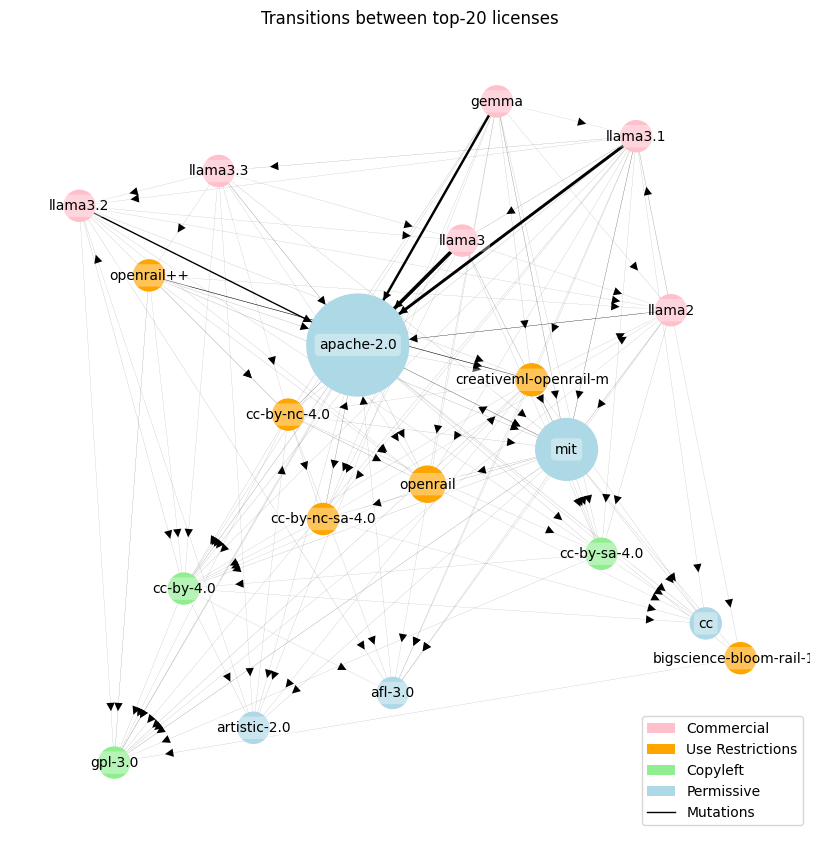

In [13]:

# Visualize the graph with the custom layout
plt.figure(figsize=(8, 8))
nx.draw(top_license_graph, pos_custom, with_labels=False, node_size=500, node_color=node_colors#"lightblue"
        , font_size=10, font_weight="bold", edge_color="gray", width=0.1, arrowstyle='-')
nx.draw_networkx_nodes(top_license_graph, pos_custom, node_size=[top_license_graph.nodes[node]['total_appearances'] * 0.018 for node in top_license_graph.nodes()], node_color=node_colors#"lightblue"
    )
nx.draw_networkx_edges(top_license_graph, pos_custom, node_size=1, arrowstyle='-', width=[top_license_graph[u][v]['traffic'] * 0.0003+.0001 for u, v in top_license_graph.edges()], edge_color="black",alpha=1)
#nx.draw_networkx_edges(top_license_graph, pos_custom, node_size=5000, arrowstyle='-|>', arrowsize=20, width=[top_license_graph[u][v]['traffic'] * 0.0003 + .0001 for u, v in top_license_graph.edges()], edge_color="black",alpha=1)
nx.draw_networkx_edges(top_license_graph, pos_custom, node_size=5500, arrowstyle='-|>', arrowsize=15, width=[.00001 for u, v in top_license_graph.edges()], edge_color="black",alpha=1)

# Convert labels using the license_dict
label_list = [i for i in range(len(top_license_graph.nodes()))]
nx.draw_networkx_labels(top_license_graph, pos_custom, font_size=10, font_family="sans-serif",
                        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.35))

plt.title("Transitions between top-{} licenses".format(n))

# Create a legend for the node colors. These should be squares not lines.
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor='pink', linewidth=0, label='Commercial'),
                   Patch(facecolor='orange', linewidth=0, label='Use Restrictions'),
                   Patch(facecolor='lightgreen', linewidth=0, label='Copyleft'),
                   Patch(facecolor='lightblue', linewidth=0, label='Permissive'),
                   Line2D([0], [0], color='black', lw=1, label='Mutations')]
plt.legend(handles=legend_elements, loc='lower right')

# Draw the nodes with the specified colors
#nx.draw_networkx_nodes(top_license_graph, pos_custom, node_size=[top_license_graph.nodes[node]['total_appearances'] * 0.018 for node in top_license_graph.nodes()], node_color=node_colors)

#plt.savefig("figures/top_license_graph_customlayout_n{}.png".format(n), bbox_inches='tight', dpi=300)
plt.show()

## Languages

In [14]:
language_counter = get_trait_counter(G, 'languages')
language_graph = get_trait_graph(G, 'languages', language_counter)
language_ratios = get_trait_ratios(language_graph, print_ratios=False)

#print( sorted(language_counter.items(), key=lambda x: x[1], reverse=True))

In [15]:

# Given the optimal_ordering and the trait graph, get the total traffic among all nodes in the ordering, and the total traffic among all nodes compatible with the ordering
def get_compatible_and_total_traffic(trait_graph, optimal_ordering):
    total_traffic = 0
    total_traffic_compatible_with_ordering = 0
    for i in range(len(optimal_ordering)):
        for j in range(i+1, len(optimal_ordering)):
            if trait_graph.has_edge(optimal_ordering[j], optimal_ordering[i]):
                total_traffic += trait_graph[optimal_ordering[j]][optimal_ordering[i]]['transitions']
            if trait_graph.has_edge(optimal_ordering[i], optimal_ordering[j]):
                total_traffic += trait_graph[optimal_ordering[i]][optimal_ordering[j]]['transitions']
                total_traffic_compatible_with_ordering += trait_graph[optimal_ordering[i]][optimal_ordering[j]]['transitions']
    return total_traffic_compatible_with_ordering, total_traffic

#total_traffic, total_traffic_compatible_with_ordering = get_compatible_and_total_traffic(language_graph, ordering_weighted)

# Get the total traffic of the trait graph
#total_traffic_of_trait_graph = sum(data['traffic'] for _, _, data in trait_graph.edges(data=True))
#print(total_traffic_of_trait_graph)


In [16]:
oriented_language_graph = get_oriented_trait_graph(language_graph)
oriented_language_graph = append_total_appearances(oriented_language_graph, language_counter)

n = 20

top_language_graph = get_top_trait_graph(oriented_language_graph, n)

Removed 0 traits: []


In [17]:
ordering_unweighted, compatible_count = solve_max_compatible_ordering(top_language_graph)

ordering_weighted, total_weight = solve_weighted_compatible_ordering(top_language_graph)

compatible_edges_weighted = count_compatible_edges(top_language_graph, ordering_weighted)

total_traffic_top_traits = sum(data['traffic'] for _, _, data in top_language_graph.edges(data=True))
total_edges_top_traits = top_language_graph.number_of_edges()
total_n_top_traits = sum(data['total_n'] for _, _, data in top_language_graph.edges(data=True))

accounted_for_mutations_weightedordering, total_mutations = get_compatible_and_total_traffic(language_graph, ordering_weighted)

print(f"Ordering unweighted: {ordering_unweighted}")
print(f"Ordering weighted: {ordering_weighted}")
print(f"Total traffic: {total_traffic_top_traits}")
print(f"Total n: {total_n_top_traits}")
print(f"Compatible count: {compatible_count}")
print(f"Compatible edges weighted: {compatible_edges_weighted}")
print(f"Total edges: {total_edges_top_traits}")
print(f"Total weight: {total_weight}")

print("Oriented graph compatibility: " + str(compatible_edges_weighted) + " / " + str(total_edges_top_traits) + " (" + str(compatible_edges_weighted / total_edges_top_traits) + ")")
print("Mutations accounted for: " + str(accounted_for_mutations_weightedordering) + " / " + str(total_mutations) + " (" + str(accounted_for_mutations_weightedordering / total_mutations) + ")")

Ordering unweighted: ['Polish', 'Swedish', 'Thai', 'Italian', 'Romanian', 'Portuguese', 'Dutch', 'German', 'French', 'Japanese', 'Indonesian', 'Vietnamese', 'Turkish', 'Russian', 'Spanish', 'Chinese', 'Arabic', 'Hindi', 'Korean', 'English']
Ordering weighted: ['Polish', 'Swedish', 'Thai', 'Italian', 'Portuguese', 'Japanese', 'Romanian', 'Dutch', 'German', 'French', 'Indonesian', 'Vietnamese', 'Turkish', 'Russian', 'Spanish', 'Chinese', 'Arabic', 'Hindi', 'Korean', 'English']
Total traffic: 59400
Total n: 118568
Compatible count: 187
Compatible edges weighted: 186
Total edges: 189
Total weight: 59369.0
Oriented graph compatibility: 186 / 189 (0.9841269841269841)
Mutations accounted for: 89028 / 118718 (0.749911555113799)


In [18]:
# Count all the weights on the edges in the graph
total_traffic_all_traits = sum(data['traffic'] for _, _, data in oriented_language_graph.edges(data=True))
total_edges_all_traits = oriented_language_graph.number_of_edges()
total_n_all_traits = sum(data['total_n'] for _, _, data in oriented_language_graph.edges(data=True))

print(f"Total traffic (all traits): {total_traffic_all_traits}")
print(f"Total n (all traits): {total_n_all_traits}")
print(f"Total edges (all traits): {total_edges_all_traits}")


Total traffic (all traits): 492199
Total n (all traits): 721373
Total edges (all traits): 10372


In [19]:
# Create a custom layout based on ordering_weighted
pos_custom = {}
x_values = random.sample(range(len(ordering_weighted)), len(ordering_weighted))
for i, node in enumerate(ordering_weighted):
    pos_custom[node] = (x_values[i], len(ordering_weighted) - i)

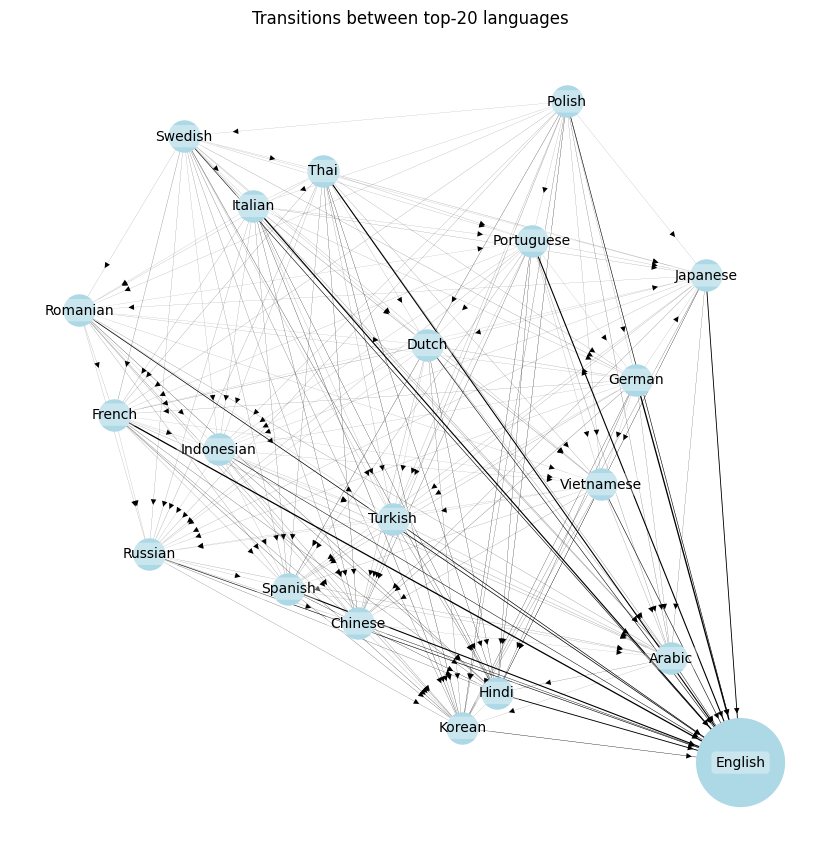

In [20]:
# Visualize the graph with the custom layout
plt.figure(figsize=(8, 8))
nx.draw(top_language_graph, pos_custom, with_labels=False, node_size=500, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray", width=0.1, arrowstyle='-')
nx.draw_networkx_nodes(top_language_graph, pos_custom, node_size=[top_language_graph.nodes[node]['total_appearances'] * 0.018 for node in top_language_graph.nodes()], node_color="lightblue")
nx.draw_networkx_edges(top_language_graph, pos_custom, node_size=1, arrowstyle='-', width=[top_language_graph[u][v]['traffic'] * 0.0003 for u, v in top_language_graph.edges()], edge_color="black")
#nx.draw_networkx_edges(top_language_graph, pos_custom, node_size=5000, arrowstyle='->', arrowsize=40, width=[top_language_graph[u][v]['traffic'] * 0.0003 for u, v in top_language_graph.edges()], edge_color="gray")
nx.draw_networkx_edges(top_language_graph, pos_custom, node_size=5000, arrowstyle='-|>', arrowsize=10, width=[.00001 for u, v in top_language_graph.edges()], edge_color="black")

# Convert labels using the task_dict
label_list = [i for i in range(len(top_language_graph.nodes()))]
nx.draw_networkx_labels(top_language_graph, pos_custom, font_size=10, font_family="sans-serif",
                        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.35))

plt.title("Transitions between top-{} languages".format(n))
#plt.savefig("figures/top_language_graph_customlayout_n{}.png".format(n), bbox_inches='tight', dpi=300)
plt.show()

# Libraries

In [21]:
library_counter = get_trait_counter(G, 'library_name')

library_graph = get_trait_graph(G, 'library_name', library_counter)

library_ratios = get_trait_ratios(library_graph, print_ratios=False)

#print(sorted(library_counter.items(), key=lambda x: x[1], reverse=True))

In [22]:
oriented_library_graph = get_oriented_trait_graph(library_graph)
oriented_library_graph = append_total_appearances(oriented_library_graph, library_counter)

n = 10

top_library_graph = get_top_trait_graph(oriented_library_graph, n)

Removed 0 traits: []


In [23]:
ordering_unweighted, compatible_count = solve_max_compatible_ordering(top_library_graph)

ordering_weighted, total_weight = solve_weighted_compatible_ordering(top_library_graph)

total_traffic = sum(data['traffic'] for _, _, data in top_library_graph.edges(data=True))
total_edges = top_library_graph.number_of_edges()
total_n = sum(data['total_n'] for _, _, data in top_library_graph.edges(data=True))

accounted_for_mutations_weightedordering, total_mutations = get_compatible_and_total_traffic(library_graph, ordering_weighted)

print(f"Ordering unweighted: {ordering_unweighted}")
print(f"Ordering weighted: {ordering_weighted}")
print(f"Total traffic: {total_traffic}")
print(f"Total n: {total_n}")
print(f"Compatible count: {compatible_count}")
print(f"Total edges: {total_edges}")
print(f"Total weight: {total_weight}")

print("Oriented graph compatibility: " + str(compatible_count) + " / " + str(total_edges) + " (" + str(compatible_count / total_edges) + ")")
print("Mutations accounted for: ", accounted_for_mutations_weightedordering / total_mutations)

Ordering unweighted: ['peft', 'adapter-transformers', 'timm', 'transformers', 'diffusers', 'mlx', 'ml-agents', 'tf-keras', 'sentence-transformers', 'keras']
Ordering weighted: ['peft', 'adapter-transformers', 'timm', 'transformers', 'diffusers', 'mlx', 'ml-agents', 'tf-keras', 'sentence-transformers', 'keras']
Total traffic: 4218
Total n: 6266
Compatible count: 17
Total edges: 17
Total weight: 4218.0
Oriented graph compatibility: 17 / 17 (1.0)
Mutations accounted for:  0.8365783593999362


In [24]:
# Create a custom layout based on ordering_weighted
pos_custom = {}
x_values = random.sample(range(len(ordering_weighted)), len(ordering_weighted))
for i, node in enumerate(ordering_weighted):
    pos_custom[node] = (x_values[i], len(ordering_weighted) - i)

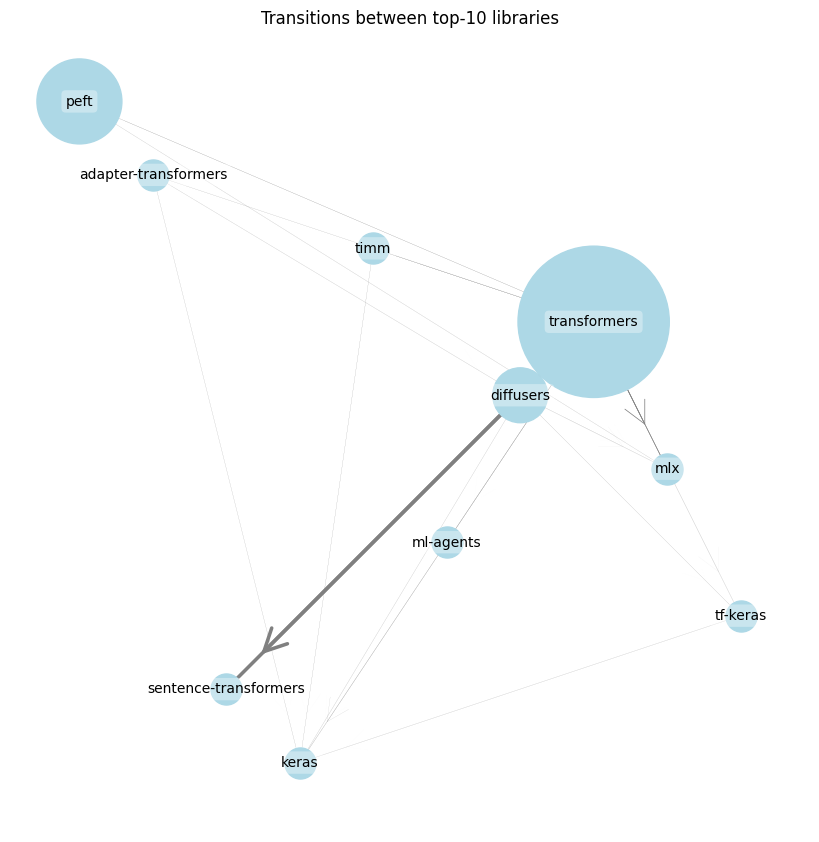

In [25]:
# Visualize the graph with the custom layout
plt.figure(figsize=(8, 8))
nx.draw(top_library_graph, pos_custom, with_labels=False, node_size=500, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray", width=0.1, arrowstyle='-')
nx.draw_networkx_nodes(top_library_graph, pos_custom, node_size=[top_library_graph.nodes[node]['total_appearances'] * 0.018 for node in top_library_graph.nodes()], node_color="lightblue")
nx.draw_networkx_edges(top_library_graph, pos_custom, node_size=1, arrowstyle='-', width=[top_library_graph[u][v]['traffic'] * 0.0008 for u, v in top_library_graph.edges()], edge_color="gray")
nx.draw_networkx_edges(top_library_graph, pos_custom, node_size=5000, arrowstyle='->', arrowsize=40, width=[top_library_graph[u][v]['traffic'] * 0.0008 for u, v in top_library_graph.edges()], edge_color="gray")

# Convert labels using the task_dict
label_list = [i for i in range(len(top_library_graph.nodes()))]
nx.draw_networkx_labels(top_library_graph, pos_custom, font_size=10, font_family="sans-serif",
                        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.35))

plt.title("Transitions between top-{} libraries".format(n))
#plt.savefig("figures/top_library_graph_customlayout_n{}.png".format(n), bbox_inches='tight', dpi=300)
plt.show()

# Tasks

In [26]:
task_counter = get_trait_counter(G, 'pipeline_tag')
task_graph = get_trait_graph(G, 'pipeline_tag', task_counter)
task_ratios = get_trait_ratios(task_graph, print_ratios=False)

#print(sorted(task_counter.items(), key=lambda x: x[1], reverse=True))

In [27]:
oriented_task_graph = get_oriented_trait_graph(task_graph)
oriented_task_graph = append_total_appearances(oriented_task_graph, task_counter)

n = 10

top_task_graph = get_top_trait_graph(oriented_task_graph, n)

Removed 0 traits: []


In [28]:
ordering_unweighted, compatible_count = solve_max_compatible_ordering(top_task_graph)

ordering_weighted, total_weight = solve_weighted_compatible_ordering(top_task_graph)

total_traffic = sum(data['traffic'] for _, _, data in top_task_graph.edges(data=True))
total_edges = top_task_graph.number_of_edges()
total_n = sum(data['total_n'] for _, _, data in top_task_graph.edges(data=True))

accounted_for_mutations_weightedordering, total_mutations = get_compatible_and_total_traffic(task_graph, ordering_weighted)

print(f"Ordering unweighted: {ordering_unweighted}")
print(f"Ordering weighted: {ordering_weighted}")
print(f"Total traffic: {total_traffic}")
print(f"Total n: {total_n}")
print(f"Compatible count: {compatible_count}")
print(f"Total edges: {total_edges}")
print(f"Total weight: {total_weight}")

print("Oriented graph compatibility: " + str(compatible_count) + " / " + str(total_edges) + " (" + str(compatible_count / total_edges) + ")")
print("Mutations accounted for: ", accounted_for_mutations_weightedordering / total_mutations)

Ordering unweighted: ['fill-mask', 'text-to-image', 'feature-extraction', 'automatic-speech-recognition', 'question-answering', 'text-generation', 'image-classification', 'text-classification', 'reinforcement-learning', 'token-classification']
Ordering weighted: ['fill-mask', 'feature-extraction', 'automatic-speech-recognition', 'question-answering', 'text-generation', 'text-to-image', 'image-classification', 'text-classification', 'reinforcement-learning', 'token-classification']
Total traffic: 75232
Total n: 78012
Compatible count: 30
Total edges: 32
Total weight: 75214.0
Oriented graph compatibility: 30 / 32 (0.9375)
Mutations accounted for:  0.9819267842493847


In [29]:
total_traffic_all_traits = sum(data['traffic'] for _, _, data in oriented_task_graph.edges(data=True))
total_edges_all_traits = oriented_task_graph.number_of_edges()
total_n_all_traits = sum(data['total_n'] for _, _, data in oriented_task_graph.edges(data=True))

print(f"Total traffic (all traits): {total_traffic_all_traits}")
print(f"Total n (all traits): {total_n_all_traits}")
print(f"Total edges (all traits): {total_edges_all_traits}")

Total traffic (all traits): 103690
Total n (all traits): 110542
Total edges (all traits): 275


In [30]:
# Create a custom layout based on ordering_weighted
pos_custom = {}
x_values = random.sample(range(len(ordering_weighted)), len(ordering_weighted))
for i, node in enumerate(ordering_weighted):
    pos_custom[node] = (x_values[i], len(ordering_weighted) - i)

In [31]:
feature_manipulation = ['feature-extraction','fill-mask','sentence-similarity']
translation_like = ['any-to-any','image-text-to-text','','automatic-speech-recognition','text-to-speech','translation','question-answering','summarization','text-generation','text-to-image','image-to-text','audio-to-audio']
classification = ['image-classification','text-classification','audio-classification','video-classification','token-classification','code-classification','object-detection']
rl_like = ['reinforcement-learning']

# Define a color map for the nodes based on their categories
node_colors = []
for node in top_task_graph.nodes():
    if node in feature_manipulation:
        node_colors.append('#FFC0CB') # colors close to pink include: #FFC0CB, #FFB6C1, #FF69B4, #FF1493, #FF00FF. Colors close to light red include #FF69B4, #FF1493, #FF00FF.
    elif node in translation_like:
        node_colors.append('#FFA500') # colors close to light orange include: #FFA500, #FF8C00, #FF7F50, #FF6347, #FF4500. Lighter: #FFDAB9, #FFE4C4, #FFE4B5, #FFE4C1, #FFE4B5.
    elif node in classification:
        node_colors.append('lightgreen')
    elif node in rl_like:
        node_colors.append('lightblue')
    else:
        node_colors.append('gray')  # Default color for nodes not in any category


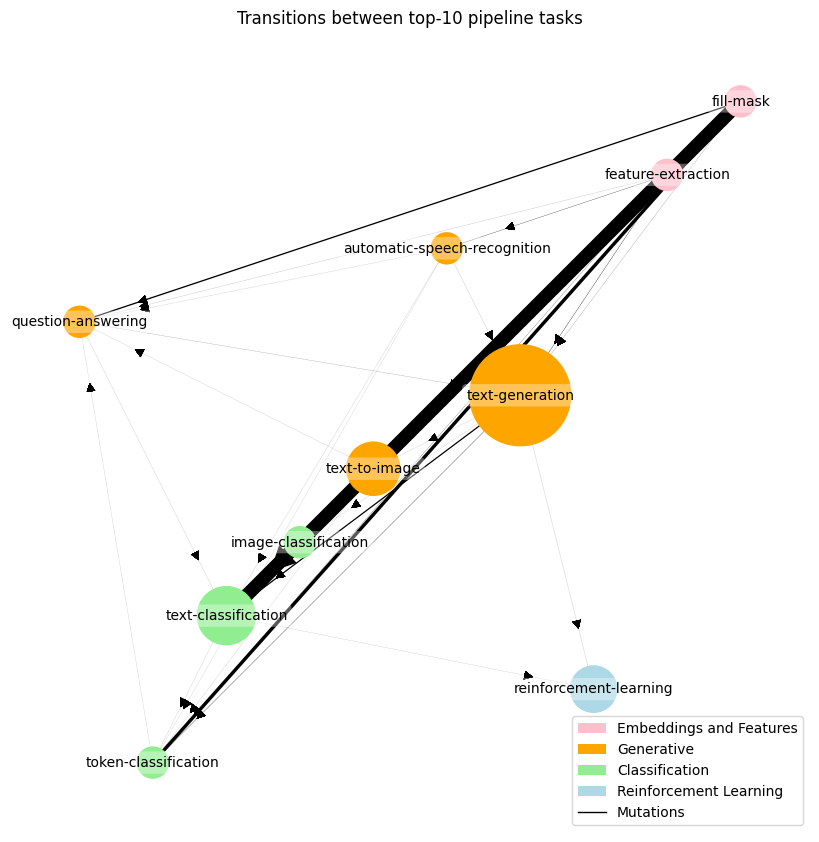

In [32]:
# Visualize the graph with the custom layout
plt.figure(figsize=(8, 8))

nx.draw(top_task_graph, pos_custom, with_labels=False, node_size=500, node_color=node_colors, font_size=10, font_weight="bold", edge_color="gray", width=0.1, arrowstyle='-')
nx.draw_networkx_nodes(top_task_graph, pos_custom, node_size=[top_task_graph.nodes[node]['total_appearances'] * 0.018 for node in top_task_graph.nodes()], node_color=node_colors)
nx.draw_networkx_edges(top_task_graph, pos_custom, node_size=1, arrowstyle='-', width=[top_task_graph[u][v]['traffic'] * 0.0002+.0001 for u, v in top_task_graph.edges()], edge_color="black")
#nx.draw_networkx_edges(top_task_graph, pos_custom, node_size=5000, arrowstyle='->', arrowsize=40, width=[top_task_graph[u][v]['traffic'] * 0.0003 for u, v in top_task_graph.edges()], edge_color="black")
nx.draw_networkx_edges(top_task_graph, pos_custom, node_size=8000, arrowstyle='-|>', arrowsize=15, width=[.00001 for u, v in top_task_graph.edges()], edge_color="black")
# On only the edge between 'fill-mask' and 'text-classification' make the arrow size (arrowsize) thicker (e.g. x3)
for u, v in top_task_graph.edges():
    if u == 'fill-mask' and v == 'text-classification':
        nx.draw_networkx_edges(top_task_graph.subgraph(['fill-mask', 'text-classification']), pos_custom, node_size=8000, arrowstyle='-|>', arrowsize=45, width=.00001, edge_color="black")
    else:
        nx.draw_networkx_edges(top_task_graph, pos_custom, node_size=8000, arrowstyle='-|>', arrowsize=15, width=.00001, edge_color="black")

# Convert labels using the task_dict
label_list = [i for i in range(len(top_task_graph.nodes()))]
nx.draw_networkx_labels(top_task_graph, pos_custom, font_size=10, font_family="sans-serif",
                        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.35))

# Create a legend for the node colors. These should be squares not lines.
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor='#FFC0CB', linewidth=0, label='Embeddings and Features'),
                   Patch(facecolor='#FFA500', linewidth=0, label='Generative'),
                   Patch(facecolor='lightgreen', linewidth=0, label='Classification'),
                   Patch(facecolor='lightblue', linewidth=0, label='Reinforcement Learning'),
                   Line2D([0], [0], color='black', lw=1, label='Mutations')]
plt.legend(handles=legend_elements, loc='lower right')


plt.title("Transitions between top-{} pipeline tasks".format(n))
#plt.savefig("figures/top_task_graph_customlayout_n{}.png".format(n), bbox_inches='tight', dpi=300)
plt.show()

## Configurable version

Here we implement a configurable version where we can drag around the nodes.

In [33]:
import dash
import dash_cytoscape as cyto
import networkx as nx
from dash import html

# Create a graph

# Convert to Cytoscape format
nodes = [{"data": {"id": node, "label": node}} for node in top_language_graph.nodes()]
edges = [{"data": {"source": u, "target": v}} for u, v in top_language_graph.edges()]

app = dash.Dash(__name__)
app.layout = html.Div([
    cyto.Cytoscape(
        id='cytoscape',
        elements=nodes + edges,
        style={'width': '100%', 'height': '600px'},
        layout={'name': 'cose'},  # use 'preset' for fixed, 'cose' for dynamic layout
        stylesheet=[
            {
                "selector": "node",
                "style": {
                    "content": "data(label)",
                    "text-valign": "center",
                    "color": "white",
                    "background-color": "#0074D9",
                    "width": 40,
                    "height": 40,
                    "font-size": "12px"
                }
            },
            {
                "selector": "edge",
                "style": {
                    "curve-style": "bezier",
                    "target-arrow-shape": "triangle",
                    "arrow-scale": 1,
                    "line-color": "#ccc",
                    "target-arrow-color": "#ccc"
                }
            }
        ]
    )
])

if __name__ == '__main__':
    app.run(debug=True)